In [ ]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import gc

# ------------------------------------------------------------
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression

# ------------------------------------------------------------
from lightgbm import LGBMClassifier

# ------------------------------------------------------------
from keras import Sequential, regularizers
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, Callback

In [ ]:
# Включаем автоматическую сборку мусора

gc.enable()

In [ ]:
# Загружаем данные

application = pd.read_csv("/kaggle/input/after-manual-feature-generation/application.csv")

In [ ]:
# Проверяем

application.shape

(356255, 265)

In [ ]:
# Преобразовываем float 64 в float 32 для уменьшения использования памяти

float_cols = application.select_dtypes(include=["float64"]).columns
application[float_cols] = application[float_cols].astype(np.float32)

In [ ]:
# label encoding для категориальных переменных

categorical_features = [
    "NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR",\
    "FLAG_OWN_REALTY", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE",\
    "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE",\
    "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE",\
    "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE",\
    "EMERGENCYSTATE_MODE", "mode_accompanied_client_list",\
    "mode_client_type_list", "mode_portfolio_list",\
    "mode_channel_type_list", "mode_seller_type_list",\
    "main_reason_refusal_list"
]

le = LabelEncoder()

application[categorical_features] = application[categorical_features].fillna("Unknown")

for feature in categorical_features:
    le.fit(application[feature])
    application[feature] = le.transform(application[feature])

In [ ]:
# Проверяем

application.shape

(356255, 265)

# **Загрузка дополнительных таблиц**

In [ ]:
# Загружаем данные

prev = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')
buro = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
buro_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
credit_card  = pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')
POS_CASH  = pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')
payments = pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')

# **Данные кредитного бюро по ежемесячному балансу кредитов**

In [ ]:
# Посмотрим на buro_balance

buro_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
# Статусы в buro_balance

buro_balance.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [ ]:
# Создаем новые признаки
buro_grouped_size = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].size()
buro_grouped_max = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].max()
buro_grouped_min = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min()

# Группируем и применяем unstack
buro_counts = buro_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize = False)
buro_counts_unstacked = buro_counts.unstack('STATUS')
buro_counts_unstacked.columns = ['STATUS_0', 'STATUS_1','STATUS_2','STATUS_3','STATUS_4','STATUS_5','STATUS_C','STATUS_X',]
buro_counts_unstacked['MONTHS_COUNT'] = buro_grouped_size
buro_counts_unstacked['MONTHS_MIN'] = buro_grouped_min
buro_counts_unstacked['MONTHS_MAX'] = buro_grouped_max

# Присоединяем buro_counts_unstacked к таблице buro
buro = buro.join(buro_counts_unstacked, how='left', on='SK_ID_BUREAU')

In [ ]:
# Удаляем buro_balance

del buro_balance

gc.collect()

23

# **Общие данные по кредитным бюро**

In [ ]:
# Посмотрим на buro

buro.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_COUNT,MONTHS_MIN,MONTHS_MAX
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Закодируем категориальные признаки
buro_cat_features = [bcol for bcol in buro.columns if buro[bcol].dtype == 'object']
buro = pd.get_dummies(buro, columns=buro_cat_features)

# Группируем, подготавливаем для объединения с основной таблицей

avg_buro = buro.groupby('SK_ID_CURR').mean()
avg_buro['buro_count'] = buro[['SK_ID_BUREAU', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']

del avg_buro['SK_ID_BUREAU']

In [ ]:
# Удаляем buro

del buro

gc.collect()

46

# **Данные по предыдущим заявкам**

In [ ]:
# Посмотрим на prev

prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Закодируем категориальные признаки
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == 'object']
prev = pd.get_dummies(prev, columns=prev_cat_features)

# Группируем, подготавливаем для объединения с основной таблицей

avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()

avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']

del avg_prev['SK_ID_PREV']

In [ ]:
# Удаляем prev

del prev

gc.collect()

23

# **Баланс по кредитной карте**

In [ ]:
# Посмотрим на POS_CASH

POS_CASH.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
# Статусы в POS_CASH

POS_CASH.NAME_CONTRACT_STATUS.value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [ ]:
# Закодируем категориальные признаки

le = LabelEncoder()

POS_CASH['NAME_CONTRACT_STATUS'] = le.fit_transform(POS_CASH['NAME_CONTRACT_STATUS'].astype(str))

# Группируем, подготавливаем для объединения с основной таблицей

nunique_status = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()

POS_CASH['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
POS_CASH['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']

POS_CASH.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

# **Данные по картам**

In [ ]:
# Посмотрим на credit_card

credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
# Закодируем категориальные признаки
credit_card['NAME_CONTRACT_STATUS'] = le.fit_transform(credit_card['NAME_CONTRACT_STATUS'].astype(str))

# Группируем, подготавливаем для объединения с основной таблицей

nunique_status = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()

credit_card['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
credit_card['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']

credit_card.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

# **Данные по платежам**

In [ ]:
# Посмотрим на payments

payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [ ]:
# Создадим три таблицы (средние, минимальные и максимальные значения)

avg_payments = payments.groupby('SK_ID_CURR').mean()
avg_payments2 = payments.groupby('SK_ID_CURR').max()
avg_payments3 = payments.groupby('SK_ID_CURR').min()

del avg_payments['SK_ID_PREV']

In [ ]:
# Удаляем payments

del payments

gc.collect()

115

# **Объединение таблиц**

In [ ]:
# Объединяем все таблицы в application

application = application.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
application = application.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
application = application.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
application = application.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
application = application.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')
application = application.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')
application = application.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')

In [ ]:
# Удаляем лишние таблицы

del avg_prev, avg_buro, POS_CASH, credit_card, avg_payments, avg_payments2, avg_payments3

gc.collect()

23

In [ ]:
# Проверяем

application.shape

(356255, 524)

In [ ]:
# Сохраняем результат

application.to_csv("application_aft_merge.csv", index=False)

# **LightGBM (preparation)**

In [ ]:
import re

# Составляем регулярное выражение для поиска JSON символов
json_pattern = re.compile(r'[\{\}\[\]\"\,\:\/\+\(\)]')

# Проходимся по всем названиям столбцов и удаляем JSON символы
new_columns = []
for col in application.columns:
    new_col = json_pattern.sub('_', col)
    new_columns.append(new_col)

# Заменяем названия столбцов в DataFrame на обновленные названия без JSON символов
application.columns = new_columns

In [ ]:
# Удаляем таргет из признаков
features_to_remove = ["TARGET", "train", "SK_ID_CURR"]

# Удаляем признаки без отклонений
features_to_remove = features_to_remove + list(application.std()[application.std() == 0].index)

features = application.drop(features_to_remove, axis = 1).columns

In [ ]:
# Разделяем наборы данных для обучения и тестирования

application_train = application[application["train"] == 1]
application_test = application[application["train"] == 0]

In [ ]:
# Удаляем application dataframe из памяти

del application

gc.collect()

46

In [ ]:
# Функция для отображения использования памяти основными наборами данных

def show_mem_usage():
    '''Displays memory usage from inspection
    of global variables in this notebook'''
    gl = sys._getframe(1).f_globals
    vars= {}
    for k,v in list(gl.items()):
        # для pandas dataframes
        if hasattr(v, 'memory_usage'):
            mem = v.memory_usage(deep=True)
            if not np.isscalar(mem):
                mem = mem.sum()
            vars.setdefault(id(v),[mem]).append(k)
        vars.setdefault(id(v),[sys.getsizeof(v)]).append(k)
    total = 0
    for k,(value,*names) in vars.items():
        if value>1e6:
            print(names,"%.2fMB"%(value/1e6))
        total += value
    print("%.2fMB"%(total/1e6))

show_mem_usage()

['buro_grouped_size', 'buro_grouped_size'] 13.08MB
['buro_grouped_max', 'buro_grouped_max'] 13.08MB
['buro_grouped_min', 'buro_grouped_min'] 13.08MB
['buro_counts', 'buro_counts'] 28.82MB
['buro_counts_unstacked', 'buro_counts_unstacked'] 78.47MB
['cnt_prev', 'cnt_prev'] 5.42MB
['nunique_status', 'nunique_status'] 5.88MB
['nunique_status2', 'nunique_status2'] 5.88MB
['application_train', 'application_train'] 1092.28MB
['application_test', 'application_test'] 173.14MB
1429.24MB


# **LightGBM (modeling)**

In [ ]:
# Параметры LightGBM по умолчанию

estimator_param = {}
estimator_param["boosting_type"]="gbdt"
estimator_param["num_leaves"]=1000
estimator_param["max_depth"]=5
estimator_param["learning_rate"]=0.01
estimator_param["n_estimators"]=4500
estimator_param["subsample_for_bin"]=200000
estimator_param["objective"]="binary"
estimator_param["class_weight"]=None
estimator_param["min_split_gain"]=0.5
estimator_param["min_child_weight"]=0.001
estimator_param["min_child_samples"]=45
estimator_param["subsample"]=0.8
estimator_param["subsample_freq"]=1.0
estimator_param["bagging_freq"]=1
estimator_param["colsample_bytree"]=0.6
estimator_param["reg_alpha"]=15.0
estimator_param["reg_lambda"]=20.0
estimator_param["random_state"]=2
estimator_param["n_jobs"]=7
estimator_param["silent"]=True
estimator_param["importance_type"]="split"

In [ ]:
# Функция поиска grid search для алгоритма LGBM

def GridSearch_lgb(X, y, param_grid, cv, predict = False):
    combinations= [[]]
    params = []
    for key, vals in param_grid.items():
        combinations = [i+[j] for i in combinations for j in vals]
        params.append(key)
    for comb in combinations:
        # Определение параметров, используемых для итерации gridsearch
        for index, param in enumerate(params):
            print(param, comb[index])
            estimator_param[param] = comb[index]
        
        # Кросс валидация
        kfold = KFold(n_splits=cv, shuffle=True, random_state = 2)
        roc_auc_val_list = []
        roc_auc_train_list = []
        fpr_train_list = []
        tpr_train_list = []
        fpr_val_list = []
        tpr_val_list = []
        best_ntree_list = []
        predictions_list = []
        counter = 0
        df_train = pd.DataFrame(index = X.index)
        df_val = pd.DataFrame(index = X.index)
        cv_predict = pd.DataFrame(index = X.index)
        cv_predict["predict_proba"] = np.NaN
        for train_index, val_index in kfold.split(X, y):
            counter += 1
            df_train[str(counter)] = np.NaN
            df_val[str(counter)] = np.NaN
            # Определение обучающих и валидационных наборов для Kfold
            train_X = X.iloc[train_index]
            train_y = y.iloc[train_index]
            val_X = X.iloc[val_index]
            val_y = y.iloc[val_index]
            # Определение модели
            lgb = LGBMClassifier(boosting_type=estimator_param["boosting_type"],
                                 num_leaves=estimator_param["num_leaves"], 
                                 max_depth=estimator_param["max_depth"],
                                 learning_rate=estimator_param["learning_rate"],
                                 n_estimators=estimator_param["n_estimators"], 
                                 subsample_for_bin=estimator_param["subsample_for_bin"],
                                 objective=estimator_param["objective"],
                                 class_weight=estimator_param["class_weight"],
                                 min_split_gain=estimator_param["min_split_gain"],
                                 min_child_weight=estimator_param["min_child_weight"], 
                                 min_child_samples=estimator_param["min_child_samples"],
                                 subsample=estimator_param["subsample"],
                                 subsample_freq=estimator_param["subsample_freq"],
                                 bagging_freq = estimator_param["bagging_freq"],
                                 colsample_bytree=estimator_param["colsample_bytree"],
                                 reg_alpha=estimator_param["reg_alpha"],
                                 reg_lambda=estimator_param["reg_lambda"],
                                 random_state=estimator_param["random_state"],
                                 n_jobs=estimator_param["n_jobs"],
                                 silent=estimator_param["silent"], 
                                 importance_type=estimator_param["importance_type"]
                                )
            
            lgb.fit(train_X, train_y, early_stopping_rounds=100, eval_set = [(val_X, val_y)], eval_metric='auc', verbose =0)
            predictions_train = lgb.predict_proba(train_X, num_iteration = lgb.best_iteration_)
            predictions_val = lgb.predict_proba(val_X, num_iteration = lgb.best_iteration_)
            if predict == True:
                cv_predict["predict_proba"].iloc[val_index] = predictions_val[:,1]
            fpr_train, tpr_train, threshold = roc_curve(train_y, predictions_train[:,1])
            fpr_val, tpr_val, threshold = roc_curve(val_y, predictions_val[:,1])
            roc_auc_train = auc(fpr_train, tpr_train)
            roc_auc_val = auc(fpr_val, tpr_val)
            print("CV %0.1i : ROC AUC: %0.3f (n_trees: %0.1i)" % (counter, roc_auc_val, lgb.best_iteration_))
            roc_auc_train_list.append(roc_auc_train)
            roc_auc_val_list.append(roc_auc_val)
            best_ntree_list.append(round(np.mean(lgb.best_iteration_)))
            fpr_train_list.append(fpr_train)
            tpr_train_list.append(tpr_train)
            fpr_val_list.append(fpr_val)
            tpr_val_list.append(tpr_val)

        avg_auc_train = np.mean(roc_auc_train_list)
        avg_auc_val = np.mean(roc_auc_val_list)
        std_auc_val = np.std(roc_auc_val_list)
        best_nb_iter = round(np.mean(best_ntree_list))
        print("ROC AUC: %0.4f +/- %0.4f (n_trees: %0.1i)" % (avg_auc_val, std_auc_val * 2, best_nb_iter))
                
        fig, ax = plt.subplots(figsize=(10,9))
        plt.title("Receiver operating characteristic for training and validation data with Gradient Boosting model", y = 1.03)
        for iteration in range(cv):
            if iteration == 0:
                ax.plot(fpr_train_list[iteration], tpr_train_list[iteration], label = 'Train data (AUC = %0.3f)' % avg_auc_train, color = pal.as_hex()[0])
                ax.plot(fpr_val_list[iteration], tpr_val_list[iteration], label = 'Validation data (AUC = %0.3f)' % avg_auc_val, color = pal.as_hex()[1])
            else:
                ax.plot(fpr_train_list[iteration], tpr_train_list[iteration] , color = pal.as_hex()[0])
                ax.plot(fpr_val_list[iteration], tpr_val_list[iteration], color = pal.as_hex()[1])
        ax.plot([0, 1], [0, 1], dashes = (6,4), color = pal.as_hex()[2], label = "Random decision (AUC = 0.500)")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.xlim(0,1)
        plt.ylim(0,1)
        sns.despine()
        plt.legend(loc = 'lower right')
        
        if predict == True:
            return cv_predict

In [ ]:
# Оптимизированные гиперпараметры, полученные с помощью Grid Search

param_grid = {}
param_grid["max_depth"] = [5]
param_grid["min_child_samples"] = [45]
param_grid["subsample"] = [1.0]
param_grid["subsample_freq"]=[1.0]
param_grid["colsample_bytree"]=[0.6]
param_grid["reg_alpha"] = [15]
param_grid["reg_lambda"] = [20]
param_grid["learning_rate"] = [0.01]

In [ ]:
# Прогноз кросс валидации с оптимизированными гиперпараметрами

predict_lgb = GridSearch_lgb(
    application_train[features],
    application_train["TARGET"],
    param_grid,
    cv = 5,
    predict = True
)

In [ ]:
# Определение финальной модели LightGBM

estimator_param["n_estimators"] = 4500

lgb = LGBMClassifier(
    boosting_type=estimator_param["boosting_type"],
    num_leaves=estimator_param["num_leaves"], 
    max_depth=estimator_param["max_depth"],
    learning_rate=estimator_param["learning_rate"],
    n_estimators=estimator_param["n_estimators"], 
    subsample_for_bin=estimator_param["subsample_for_bin"],
    objective=estimator_param["objective"],
    class_weight=estimator_param["class_weight"],
    min_split_gain=estimator_param["min_split_gain"],
    min_child_weight=estimator_param["min_child_weight"], 
    min_child_samples=estimator_param["min_child_samples"],
    subsample=estimator_param["subsample"],
    subsample_freq=estimator_param["subsample_freq"],
    bagging_freq = estimator_param["bagging_freq"],
    colsample_bytree=estimator_param["colsample_bytree"],
    reg_alpha=estimator_param["reg_alpha"],
    reg_lambda=estimator_param["reg_lambda"],
    random_state=estimator_param["random_state"],
    n_jobs=estimator_param["n_jobs"],
    silent=estimator_param["silent"], 
    importance_type=estimator_param["importance_type"]
)

In [ ]:
# Обучение финальной модели LightGBM

lgb.fit(application_train[features], application_train["TARGET"])

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=1.0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_freq=1, colsample_bytree=0.6, learning_rate=0.01,
               max_depth=5, min_child_samples=45, min_split_gain=0.5,
               n_estimators=4500, n_jobs=7, num_leaves=1000, objective='binary',
               random_state=2, reg_alpha=15.0, reg_lambda=20.0, silent=True,
               subsample=0.8, subsample_freq=1.0)

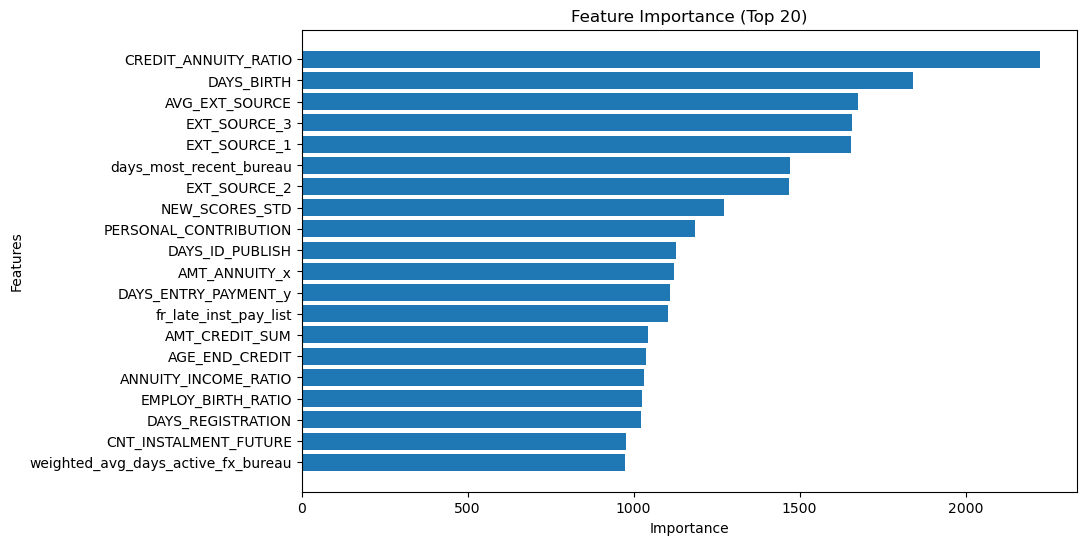

In [ ]:
# Получаем важность признаков
importance = lgb.feature_importances_
sorted_idx = np.argsort(importance)[::-1]
important_features = [features[idx] for idx in sorted_idx[:20]]

# Выводим график важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(important_features)), importance[sorted_idx[:20]][::-1])
plt.yticks(range(len(important_features)), important_features[::-1])

plt.xlabel("Importance")
plt.ylabel("Features")

plt.title("Feature Importance (Top 20)")

plt.show()

In [ ]:
# Предсказание на обучающих данных с использованием финальной модели LightGBM

predictions_lgb_train = lgb.predict_proba(application_train[features])[:,1]

print(f'TRAIN: ROC-AUC = {roc_auc_score(application_train["TARGET"], predictions_lgb_train)}')

TRAIN: ROC-AUC = 0.8523350893196547


In [ ]:
# Предсказание на тестовых данных с использованием финальной модели LightGBM

predictions_lgb_test = lgb.predict_proba(application_test[features])[:,1]

In [ ]:
# Запись предсказаний в файл отправки

predictions_id = application_test["SK_ID_CURR"]

submission_df = {
    "SK_ID_CURR": predictions_id,
    "TARGET": predictions_lgb_test
}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_lgb_6.csv", index=False)

In [ ]:
# Проверка

submission.head()

,SK_ID_CURR,TARGET
307511,100001,0.032343
307512,100005,0.156453
307513,100013,0.022909
307514,100028,0.028899
307515,100038,0.110210
